### Generate Data

In [53]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import torch
torch.backends.cudnn.allow_tf32 = False
import torch.nn as nn
import torch.optim as optim
import numpy as np
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
torch.set_default_tensor_type(torch.DoubleTensor)

# Generate synthetic data (time-to-event and censoring indicator)
np.random.seed(285714)
v_e=4; rho_e=14; v_c=3; rho_c=16

size = 10000
dim = 10

theta = 1

cuda


In [54]:
# generate X from 10 dimensional uniform distribution from 0 to 1
X = np.random.uniform(0, 1, (size, dim))
# generate censoring risk coefficient beta from 10 dimensional uniforma distribution from 0 to 1
beta_c = np.random.uniform(0, 1, (dim, ))
# generate event risk coefficient beta_e from 10 dimensional uniforma distribution from 0 to 1
beta_e = np.random.uniform(0, 1, (dim,))
# multiply beta_e with X to get event risk
event_risk = np.matmul(X, beta_e).squeeze()
# multiple beta_c with X to get censoring risk
censoring_risk = np.matmul(X, beta_c).squeeze()

#### The dependent case using Clayton Copula

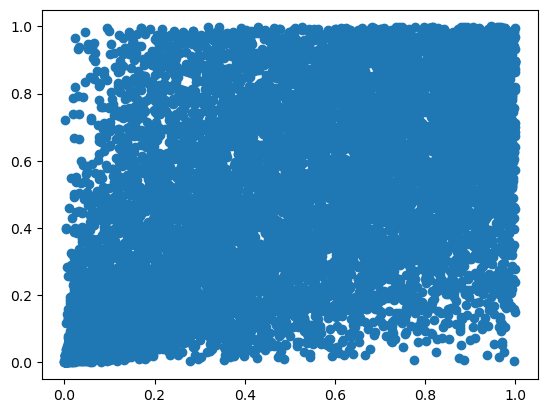

In [55]:
# define conditional distribution approach  
def clayton_conditional(u,v,theta=2):
    return (u**(-theta)*(v**(-theta/(theta+1))-1)+1)**(-1/theta)

# generate random variable uniformly from 0 to 1
u = np.random.uniform(0, 1, size)
t = np.random.uniform(0, 1, size)

# Now, (u,v) are uniformly distributed in [0,1]^2, and joint CDF is given by the Clayton Copula with parameter theta
v = clayton_conditional(u,t, theta = theta)
plt.scatter(u, v)

0.2612


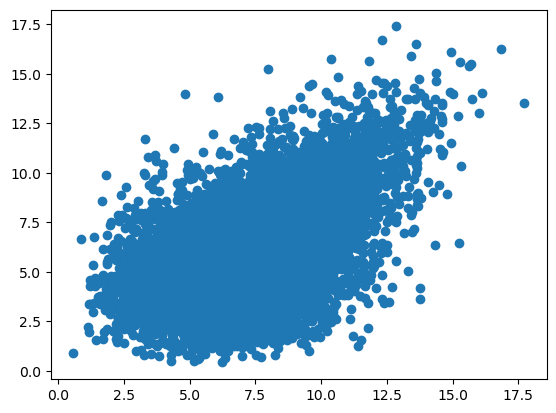

In [56]:
# Generate according to Algorithm 2 in "Copula-based Deep Survival Models for Dependent Censoring"
def inverse_transform(value, risk, shape, scale):
    return (-np.log(value)/np.exp(risk))**(1/shape)*scale       
    # return (-np.log(1-value)/np.exp(risk))**(1/shape)*scale


event_time = inverse_transform(u, event_risk, v_e, rho_e)
censoring_time = inverse_transform(v, censoring_risk, v_c, rho_c)

plt.scatter(event_time, censoring_time)

# check censoring rate 
print(np.sum(event_time<censoring_time)/len(event_time))

# create observed time 
observed_time = np.minimum(event_time, censoring_time)
event_indicator = (event_time<censoring_time).astype(int)

#### Fit maximum likelihood model that assumes Random Censoring

In [57]:
# Define our Weibull survival model
class WeibullModel(nn.Module):
    def __init__(self, num_features, hidden_size = 32):
        super(WeibullModel, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(num_features, hidden_size),
            nn.Linear(hidden_size, 1),
        )
        self.shape = nn.Parameter(torch.tensor(1.0))
        self.scale = nn.Parameter(torch.tensor(1.0))

    def log_likelihood(self, x, t, c):
        x_beta = self.net(x).squeeze()
        log_t_lambda = (self.shape - 1) * torch.log(t / self.scale)
        log_lambda = torch.log(self.scale)
        exp_term = - torch.exp(x_beta) * (t / self.scale) ** self.shape # Survival Function

        logL = torch.mean(c * (torch.log(self.shape) - torch.log(self.scale) \
            + x_beta + log_t_lambda + exp_term) + (1-c)* exp_term)

        return logL

In [60]:
import torch
import torch.optim as optim

# # Convert numpy data to PyTorch tensors
times_tensor = torch.tensor(observed_time).to(device)
event_indicator_tensor = torch.tensor(event_indicator).to(device)
covariate_tensor = torch.tensor(X).to(device)

# Define our Weibull survival model
model = WeibullModel(dim).to(device)

# Create an optimizer
optimizer = optim.AdamW( [{"params": [model.scale], "lr": 0.01},
                          {"params": [model.shape], "lr": 0.01},
                          {"params": model.net.parameters(), "lr": 0.0001}
                          ])
# optimizer = optim.AdamW(model2.parameters(), lr=0.01)

# Define the number of epochs and the likelihood threshold
num_epochs = 20000
likelihood_threshold = 1e-20

# Train the model
for epoch in range(num_epochs):
    optimizer.zero_grad()
    log_likelihood = model.log_likelihood(covariate_tensor, times_tensor, event_indicator_tensor)
    (-log_likelihood).backward()
    optimizer.step()

    if epoch % 1000 == 0:
        print(f"Epoch {epoch}, Log-Likelihood: {log_likelihood.item()}")


    # if -log_likelihood.item() < likelihood_threshold:
    #     break

print(f"Estimated Shape: {model.shape.item()}, Estimated Scale: {model.scale.item()}")

Epoch 0, Log-Likelihood: -3.9714763679495126
Epoch 1000, Log-Likelihood: -1.0565048449254868
Epoch 2000, Log-Likelihood: -0.9340584559872969
Epoch 3000, Log-Likelihood: -0.9136341691783021
Epoch 4000, Log-Likelihood: -0.8983630778791918
Epoch 5000, Log-Likelihood: -0.8837791395262768
Epoch 6000, Log-Likelihood: -0.8733325931544809
Epoch 7000, Log-Likelihood: -0.8688473459641309
Epoch 8000, Log-Likelihood: -0.86796834070591
Epoch 9000, Log-Likelihood: -0.8678883536031399
Epoch 10000, Log-Likelihood: -0.8678777236355567
Epoch 11000, Log-Likelihood: -0.867874847953759
Epoch 12000, Log-Likelihood: -0.8678739533011526
Epoch 13000, Log-Likelihood: -0.8678736629548992
Epoch 14000, Log-Likelihood: -0.8678735665653149
Epoch 15000, Log-Likelihood: -0.867873534119636
Epoch 16000, Log-Likelihood: -0.8678735230966461
Epoch 17000, Log-Likelihood: -0.8678735194774835
Epoch 18000, Log-Likelihood: -0.8678737563709642
Epoch 19000, Log-Likelihood: -0.8678737732218667
Estimated Shape: 3.2178790706729092, 

#### Define a likelihood with Clayton Copula

In [47]:
# According to UAI2023 paper
def log_clayton_partial_u(u, v, theta):
    result = torch.where ( (u.pow(-theta) + v.pow(-theta)) > 1, (-theta-1)*torch.log(u)  + (-(theta+1)/(theta))*torch.log(u.pow(-theta) + v.pow(-theta) - 1), 0)
    return result
# if u or v is too small, then u.pow(-theta) wil be inf

def log_survival(t, shape, scale, risk):
    return -(torch.exp(risk + shape*torch.log(t) - shape*torch.log(scale))) # used log transform to avoid numerical issue

def survival(t, shape, scale, risk):
    return torch.exp(log_survival(t, shape, scale, risk))

def log_density(t,shape,scale,risk):
    log_hazard = risk + shape*torch.log(t) - shape*torch.log(scale )\
         + torch.log(1/t) + torch.log(shape)
    return log_hazard + log_survival(t, shape, scale, risk)

# Define our Weibull survival model with Clayton Copula
class WeibullModelClayton(nn.Module):
    def __init__(self, num_features, hidden_size = 32):
        super(WeibullModelClayton, self).__init__()
        self.net_t = nn.Sequential(
            nn.Linear(num_features, hidden_size),
            nn.Linear(hidden_size, 1),
        )
        self.net_c = nn.Sequential(
            nn.Linear(num_features, hidden_size),
            nn.Linear(hidden_size, 1),
        )
        self.shape_t = nn.Parameter(torch.tensor(1.0)) # Event Weibull Shape
        self.scale_t = nn.Parameter(torch.tensor(1.0)) # Event Weibull Scale
        self.shape_c = nn.Parameter(torch.tensor(1.0)) # Censoring Weibull Shape   
        self.scale_c = nn.Parameter(torch.tensor(1.0)) # Censoring Weibull Scale
        self.theta = nn.Parameter(torch.tensor(1.0)) # Clayton Copula Theta
    def log_likelihood(self, x, t, c):
        x_beta_t = self.net_t(x).squeeze()
        x_beta_c = self.net_c(x).squeeze()

        # In event density, censoring entries should be 0
        event_log_density = c * log_density(t, self.shape_t, self.scale_t, x_beta_t) 
        censoring_log_density = (1-c) * log_density(t, self.shape_c, self.scale_c, x_beta_c)

        S_E = survival(t, self.shape_t, self.scale_t, x_beta_t)
        S_C = survival(t, self.shape_c, self.scale_c, x_beta_c)
        event_partial_copula = c * log_clayton_partial_u(S_E, S_C, self.theta)
        censoring_partial_copula = (1-c) * log_clayton_partial_u(S_C, S_E, self.theta)
        
        
        logL = event_log_density + event_partial_copula + censoring_log_density + censoring_partial_copula
    
        return torch.mean(logL), torch.mean(event_log_density), torch.mean(event_partial_copula), torch.mean(censoring_log_density), torch.mean(censoring_partial_copula)

In [48]:
import wandb
# torch.backends.cudnn.allow_tf32 = False
from torch.utils.data import TensorDataset, DataLoader

# # Convert numpy data to PyTorch tensors
times_tensor = torch.tensor(observed_time).to(device)
event_indicator_tensor = torch.tensor(event_indicator).to(device)
covariate_tensor = torch.tensor(X).to(device)
dataset = TensorDataset(covariate_tensor, times_tensor, event_indicator_tensor)

batch_size = 20000
dataloader = DataLoader(dataset, batch_size=batch_size)

# Define our Weibull survival model
model3 = WeibullModelClayton(dim).to(device)

# Create an optimizer
# optimizer_event = optim.Adam([{"params": [model3.scale_t], "lr": 0.05},
#                             {"params": [model3.shape_t], "lr": 0.001},
#                             {"params": model3.net_t.parameters(), "lr": 0.001},
#                           ])
# optimizer_censoring = optim.Adam([{"params": [model3.scale_c], "lr": 0.05},
#                             {"params": [model3.shape_c], "lr": 0.001},
#                             {"params": model3.net_c.parameters(), "lr": 0.001},
#                           ])
optimizer_event = optim.Adam([{"params": [model3.scale_t], "lr": 0.01},
                            {"params": [model3.shape_t], "lr": 0.01},
                            {"params": model3.net_t.parameters(), "lr": 0.01},
                          ])
optimizer_censoring = optim.Adam([{"params": [model3.scale_c], "lr": 0.01},
                            {"params": [model3.shape_c], "lr": 0.01},
                            {"params": model3.net_c.parameters(), "lr": 0.01},
                          ])
optimizer_theta = optim.Adam([{"params": [model3.theta], "lr": 0.01}])  

# Define the number of epochs and the likelihood threshold
num_epochs = 20000

# Train the model
for epoch in range(num_epochs):
    optimizer_theta.zero_grad()
    optimizer_event.zero_grad()
    optimizer_censoring.zero_grad()
    
    log_likelihood, event_log_density, event_partial_copula, censoring_log_density, censoring_partial_copula = model3.log_likelihood(covariate_tensor, times_tensor, event_indicator_tensor)
    (-log_likelihood).backward()
    
    torch.nn.utils.clip_grad_norm_(model3.parameters(), max_norm=1)

    optimizer_censoring.step()
    optimizer_event.step()
    if epoch > 10000: 
        optimizer_theta.step()

    if epoch % 1000 == 0:
        print(f"Epoch {epoch}, Log-Likelihood: {log_likelihood.item()}")
        print(f"Estimated Shape Event: {model3.shape_t.item()}, \
            Estimated Shape Censoring: {model3.shape_c.item()},\
            Estimated Theta: {model3.theta.item()}")
        
    if -log_likelihood.item() < likelihood_threshold:
        break


print(f"Estimated Shape Event: {model3.shape_t.item()}, \c\
    Estimated Shape Censoring: {model3.shape_c.item()}, \c\
    Estimated Theta: {model3.theta.item()}")

Epoch 0, Log-Likelihood: -9.194298490783057
Estimated Shape Event: 0.9900000001894061,             Estimated Shape Censoring: 1.009999999496116,            Estimated Theta: 1.0
Epoch 1000, Log-Likelihood: -2.604983665308763
Estimated Shape Event: 3.7656576891966256,             Estimated Shape Censoring: 3.0160756872448804,            Estimated Theta: 1.0
Epoch 2000, Log-Likelihood: -2.599061572961879
Estimated Shape Event: 3.8531842268908783,             Estimated Shape Censoring: 3.0291063981929156,            Estimated Theta: 1.0
Epoch 3000, Log-Likelihood: -2.6024818446249607
Estimated Shape Event: 3.8544817241188216,             Estimated Shape Censoring: 3.0287318146584865,            Estimated Theta: 1.0
Epoch 4000, Log-Likelihood: -2.6025636640946574
Estimated Shape Event: 3.8548487632146005,             Estimated Shape Censoring: 3.0287542989382388,            Estimated Theta: 1.0
Epoch 5000, Log-Likelihood: -2.599219999866677
Estimated Shape Event: 3.853583814839247,         

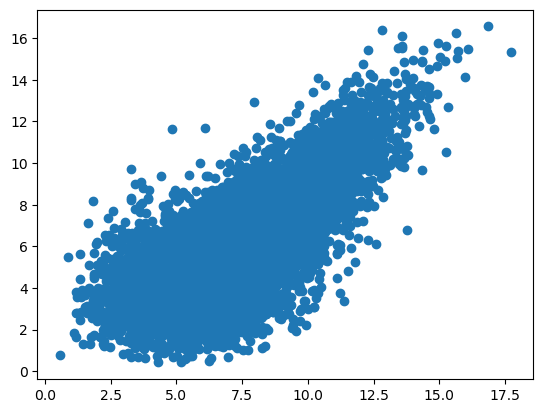

In [49]:
plt.scatter(event_time,censoring_time)

In [50]:
import sympy as sp

# Define the variables and parameter
u, v, theta = sp.symbols('u v theta')

# Define the Clayton copula function
clayton_copula = (u**(-theta) + v**(-theta) - 1)**(-1 / theta)

# Calculate the partial derivatives with respect to u and v
partial_u = sp.diff(clayton_copula, u)
partial_v = sp.diff(clayton_copula, v)

print("Partial derivative with respect to u:")
print(partial_u)
print("\nPartial derivative with respect to v:")
print(partial_v)

Partial derivative with respect to u:
1/(u*u**theta*(-1 + v**(-theta) + u**(-theta))*(-1 + v**(-theta) + u**(-theta))**(1/theta))

Partial derivative with respect to v:
1/(v*v**theta*(-1 + v**(-theta) + u**(-theta))*(-1 + v**(-theta) + u**(-theta))**(1/theta))


0.3161


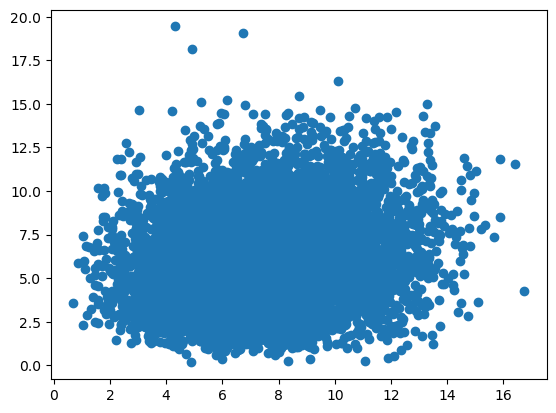

In [51]:
# generate random variable uniformly from 0 to 1
u = np.random.uniform(0, 1, size)
v = np.random.uniform(0, 1, size)
# plt.scatter(u,v)
event_time = inverse_transform(u, event_risk, v_e, rho_e)
censoring_time = inverse_transform(v, censoring_risk, v_c, rho_c)

plt.scatter(event_time, censoring_time)

# check censoring rate 
print(np.sum(event_time<censoring_time)/len(event_time))

# create observed time 
observed_time = np.minimum(event_time, censoring_time)
event_indicator = (event_time<censoring_time).astype(int)

#### The Independent Censoring Case

In [52]:
import torch
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

# # Convert numpy data to PyTorch tensors
times_tensor = torch.tensor(observed_time, dtype=torch.float32).to(device)
event_indicator_tensor = torch.tensor(event_indicator, dtype=torch.float32).to(device)
dataset = TensorDataset(times_tensor, event_indicator_tensor)

# Define our Weibull survival model
model2 = WeibullModel(dim).to(device)

# Create an optimizer
# optimizer = optim.AdamW(model2.parameters(), lr=0.01)
optimizer = optim.AdamW( [{"params": [model2.scale], "lr": 0.01},
                          {"params": [model2.shape], "lr": 0.01},
                          {"params": model2.net.parameters(), "lr": 0.0001}
                          ])
# Define the number of epochs and the likelihood threshold
num_epochs = 30000
likelihood_threshold = 1e-10

# Train the model
for epoch in range(num_epochs):
    optimizer.zero_grad()
    log_likelihood = model2.log_likelihood(covariate_tensor, times_tensor, event_indicator_tensor)
    (-log_likelihood).backward()
    optimizer.step()

    if epoch % 1000 == 0:
        print(f"Epoch {epoch}, Log-Likelihood: {log_likelihood.item()}")

print(f"Estimated Shape: {model2.shape.item()}, Estimated Scale: {model2.scale.item()}")

Epoch 0, Log-Likelihood: -7.600537017760761
Epoch 1000, Log-Likelihood: -1.3530384996494098
Epoch 2000, Log-Likelihood: -1.058110234597014
Epoch 3000, Log-Likelihood: -1.0041846201689935
Epoch 4000, Log-Likelihood: -0.981416531396757
Epoch 5000, Log-Likelihood: -0.9608198435259887
Epoch 6000, Log-Likelihood: -0.9401523366863398
Epoch 7000, Log-Likelihood: -0.9224494432470076
Epoch 8000, Log-Likelihood: -0.9138518282609494
Epoch 9000, Log-Likelihood: -0.9122176590956631
Epoch 10000, Log-Likelihood: -0.9120796591821556
Epoch 11000, Log-Likelihood: -0.912061125833764
Epoch 12000, Log-Likelihood: -0.9120559141131935
Epoch 13000, Log-Likelihood: -0.9120542544521197
Epoch 14000, Log-Likelihood: -0.9120537076337198
Epoch 15000, Log-Likelihood: -0.9120535155317666
Epoch 16000, Log-Likelihood: -0.9120534443816938
Epoch 17000, Log-Likelihood: -0.9120534223033847
Epoch 18000, Log-Likelihood: -0.9120534159620544
Epoch 19000, Log-Likelihood: -0.9120534112222577
Epoch 20000, Log-Likelihood: -0.91205